## Extracting the preprocessed data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file
df = pd.read_csv("sentence_bert_features_and_labels.csv")

# Separate features (X) and labels (y)
X = df.drop(columns=['label']).values  # Drop the label column for features
y = df['label'].values  # Extract the label column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()

print("Zeros: " + str(num_negatives))
print("Ones: " + str(num_positives))

pos_weight_value = num_negatives / num_positives

print("Ratio: " + str(pos_weight_value))

Shape of X_train: (1494, 386)
Shape of X_test: (641, 386)
Shape of y_train: (1494,)
Shape of y_test: (641,)
Zeros: 685
Ones: 809
Ratio: 0.8467243510506799


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## The neural network

In [9]:
import torch.nn as nn
import torch.optim as optim
from challenge_data.glove_nn import NeuralNet, train

# Hyperparameters
lr = 0.01
num_epochs = 200
slope = 0.01
vector_size = 200

model = NeuralNet(input_size=386, slope=slope)

criterion = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weight)  # Binary Cross Entropy Loss for binary classification

optimizer = optim.Adam(model.parameters(), lr=lr) 

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

In [10]:
from sklearn.metrics import accuracy_score
import numpy as np

# Training
loss_list = train(num_epochs=num_epochs, 
                  model=model, 
                  train_loader=train_loader, 
                  criterion=criterion, 
                  optimizer=optimizer, 
                  scheduler=scheduler,
)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_list.extend(outputs.numpy())

y_pred = (np.array(y_pred_list) > 0.5).astype(int)  # Adjust threshold for binary classification

# Print test set accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

  0%|                                                                       | 0/200 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 200/200 [01:12<00:00,  2.76it/s]

Test set accuracy: 0.6786271450858035


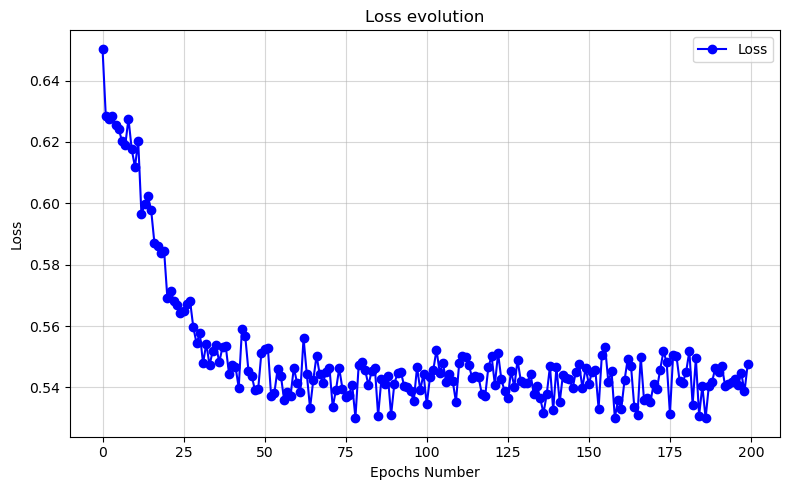

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss evolution")
plt.xlabel("Epochs Number")
plt.ylabel("Loss")
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()